In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=19.2s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Test score_cell methods

In [7]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

# facs data: n_tissue=23 n_tissue_celltype=207


In [73]:
# Assign TRS
for trait in trait_list:
    
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    print('# trait=%-40s FDR<0.1 genes=%d'%(trait, len(gene_list)))
    
    # TRS score trs_
    md.score_cell(data_facs_ct, gene_list, suffix=trait,
                  flag_correct_background=False,
                  flag_nullgene=True,
                  flag_permute_cell=True)
    
    # background-corrected TRS score: trs_bc_ 
    md.score_cell(data_facs_ct, gene_list, suffix='bc_%s'%trait,
                  flag_correct_background=True,
                  flag_nullgene=True,
                  flag_permute_cell=True)
    
#     break

# trait=PASS_MDD_Wray2018                        FDR<0.1 genes=128
# score_cell: 128/117 gene_list genes also in adata
# score_cell: suffix=PASS_MDD_Wray2018, flag_correct_background=False
# score_cell: overwrite original trs_PASS_MDD_Wray2018 in adata.obs.columns
# score_cell: 117 trait genes with mean_exp=0.120
# score_cell: 117 null_me genes with mean_exp=0.119


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 128/117 gene_list genes also in adata
# score_cell: suffix=bc_PASS_MDD_Wray2018, flag_correct_background=True
# score_cell: overwrite original trs_bc_PASS_MDD_Wray2018 in adata.obs.columns
# score_cell: 117 trait genes with mean_exp=0.120
# score_cell: 117 null_me genes with mean_exp=0.119


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_ADHD_Demontis2018                   FDR<0.1 genes=236
# score_cell: 236/214 gene_list genes also in adata
# score_cell: suffix=PASS_ADHD_Demontis2018, flag_correct_background=False
# score_cell: overwrite original trs_PASS_ADHD_Demontis2018 in adata.obs.columns
# score_cell: 214 trait genes with mean_exp=0.142
# score_cell: 214 null_me genes with mean_exp=0.136


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 236/214 gene_list genes also in adata
# score_cell: suffix=bc_PASS_ADHD_Demontis2018, flag_correct_background=True
# score_cell: 214 trait genes with mean_exp=0.142
# score_cell: 214 null_me genes with mean_exp=0.136


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_SCZvsBD_Ruderfer2018                FDR<0.1 genes=271
# score_cell: 271/256 gene_list genes also in adata
# score_cell: suffix=PASS_SCZvsBD_Ruderfer2018, flag_correct_background=False
# score_cell: 256 trait genes with mean_exp=0.136
# score_cell: 256 null_me genes with mean_exp=0.129


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 271/256 gene_list genes also in adata
# score_cell: suffix=bc_PASS_SCZvsBD_Ruderfer2018, flag_correct_background=True
# score_cell: 256 trait genes with mean_exp=0.136
# score_cell: 256 null_me genes with mean_exp=0.129


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_Coronary_Artery_Disease             FDR<0.1 genes=165
# score_cell: 165/155 gene_list genes also in adata
# score_cell: suffix=PASS_Coronary_Artery_Disease, flag_correct_background=False
# score_cell: 155 trait genes with mean_exp=0.152
# score_cell: 155 null_me genes with mean_exp=0.145


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 165/155 gene_list genes also in adata
# score_cell: suffix=bc_PASS_Coronary_Artery_Disease, flag_correct_background=True
# score_cell: 155 trait genes with mean_exp=0.152
# score_cell: 155 null_me genes with mean_exp=0.145


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_CardioembolicStroke_Malik2018       FDR<0.1 genes=54
# score_cell: 54/51 gene_list genes also in adata
# score_cell: suffix=PASS_CardioembolicStroke_Malik2018, flag_correct_background=False
# score_cell: 51 trait genes with mean_exp=0.083
# score_cell: 51 null_me genes with mean_exp=0.086


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 54/51 gene_list genes also in adata
# score_cell: suffix=bc_PASS_CardioembolicStroke_Malik2018, flag_correct_background=True
# score_cell: 51 trait genes with mean_exp=0.083
# score_cell: 51 null_me genes with mean_exp=0.086


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_LDL                                 FDR<0.1 genes=465
# score_cell: 465/430 gene_list genes also in adata
# score_cell: suffix=PASS_LDL, flag_correct_background=False
# score_cell: 430 trait genes with mean_exp=0.146
# score_cell: 430 null_me genes with mean_exp=0.139


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 465/430 gene_list genes also in adata
# score_cell: suffix=bc_PASS_LDL, flag_correct_background=True
# score_cell: 430 trait genes with mean_exp=0.146
# score_cell: 430 null_me genes with mean_exp=0.139


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_Rheumatoid_Arthritis                FDR<0.1 genes=287
# score_cell: 287/270 gene_list genes also in adata
# score_cell: suffix=PASS_Rheumatoid_Arthritis, flag_correct_background=False
# score_cell: 270 trait genes with mean_exp=0.128
# score_cell: 270 null_me genes with mean_exp=0.123


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 287/270 gene_list genes also in adata
# score_cell: suffix=bc_PASS_Rheumatoid_Arthritis, flag_correct_background=True
# score_cell: 270 trait genes with mean_exp=0.128
# score_cell: 270 null_me genes with mean_exp=0.123


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_IBD_deLange2017                     FDR<0.1 genes=1731
# score_cell: 1731/1605 gene_list genes also in adata
# score_cell: suffix=PASS_IBD_deLange2017, flag_correct_background=False
# score_cell: 1605 trait genes with mean_exp=0.143
# score_cell: 1605 null_me genes with mean_exp=0.137


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 1731/1605 gene_list genes also in adata
# score_cell: suffix=bc_PASS_IBD_deLange2017, flag_correct_background=True
# score_cell: 1605 trait genes with mean_exp=0.143
# score_cell: 1605 null_me genes with mean_exp=0.137


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# trait=PASS_Type_1_Diabetes                     FDR<0.1 genes=340
# score_cell: 340/322 gene_list genes also in adata
# score_cell: suffix=PASS_Type_1_Diabetes, flag_correct_background=False
# score_cell: 322 trait genes with mean_exp=0.121
# score_cell: 322 null_me genes with mean_exp=0.117


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# score_cell: 340/322 gene_list genes also in adata
# score_cell: suffix=bc_PASS_Type_1_Diabetes, flag_correct_background=True
# score_cell: 322 trait genes with mean_exp=0.121
# score_cell: 322 null_me genes with mean_exp=0.117


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


PASS_MDD_Wray2018


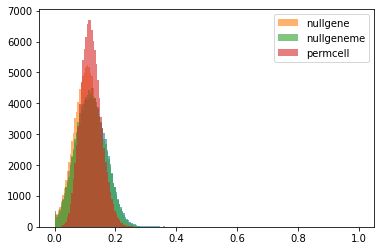

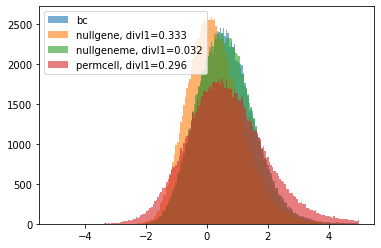

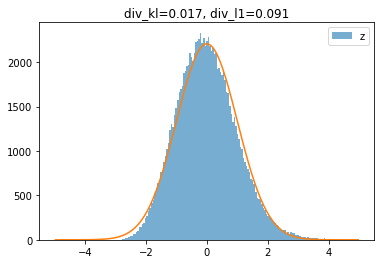

PASS_ADHD_Demontis2018


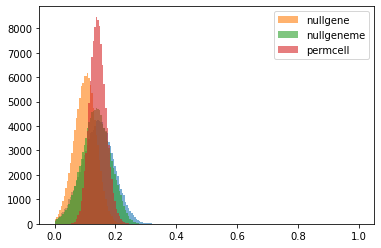

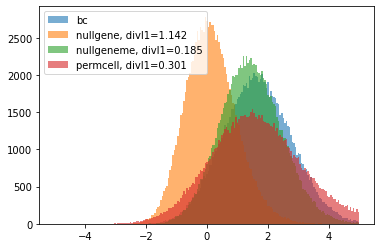

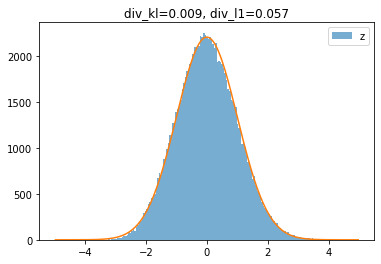

PASS_SCZvsBD_Ruderfer2018


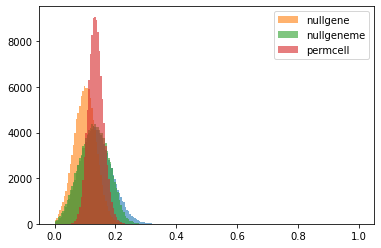

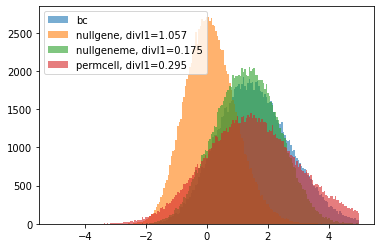

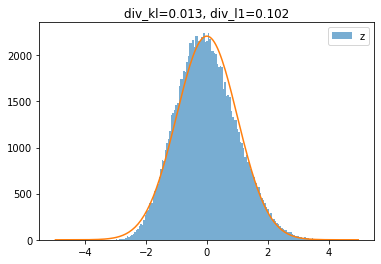

PASS_Coronary_Artery_Disease


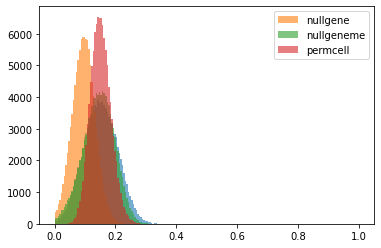

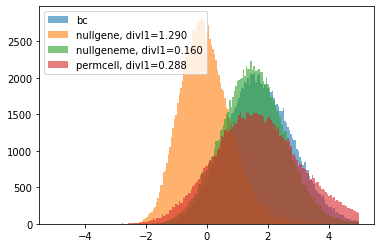

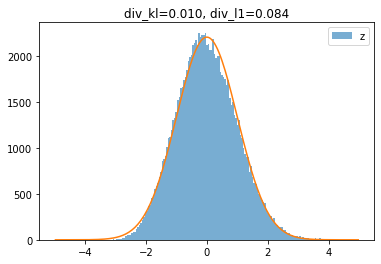

PASS_CardioembolicStroke_Malik2018


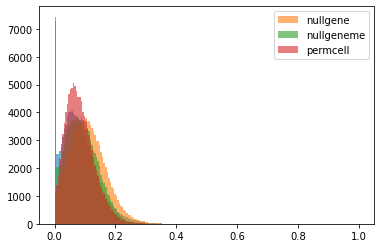

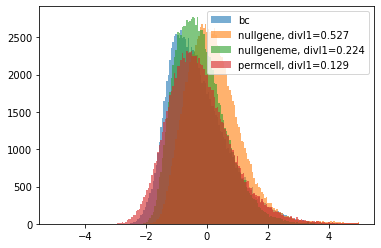

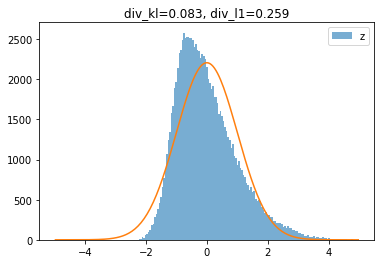

PASS_LDL


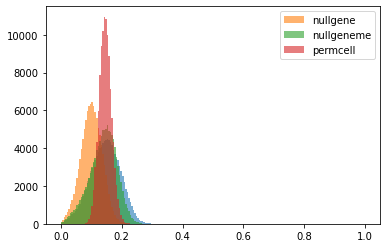

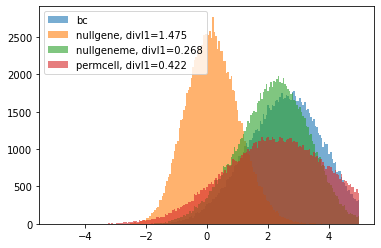

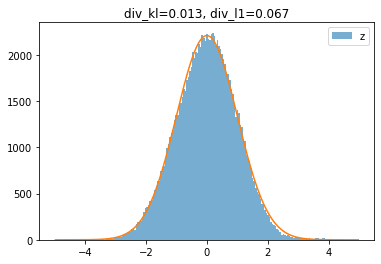

PASS_Rheumatoid_Arthritis


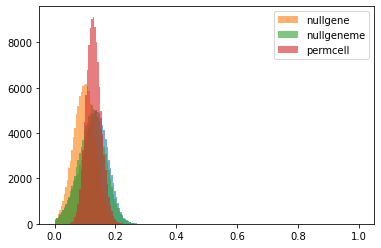

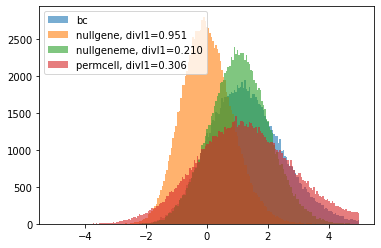

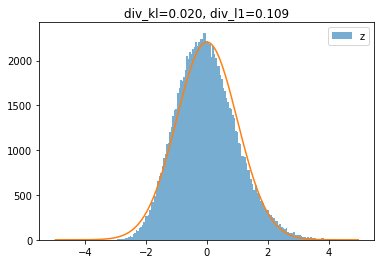

PASS_IBD_deLange2017


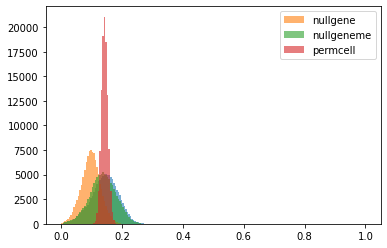

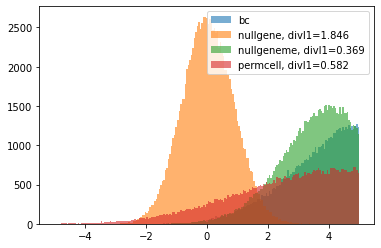

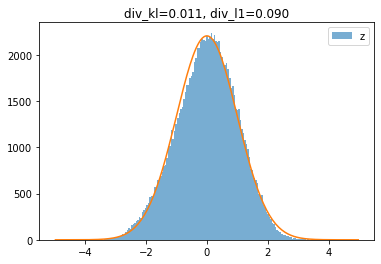

PASS_Type_1_Diabetes


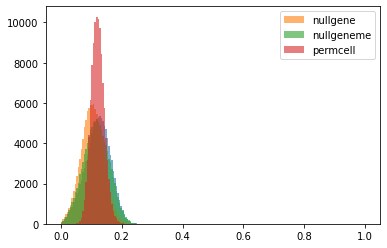

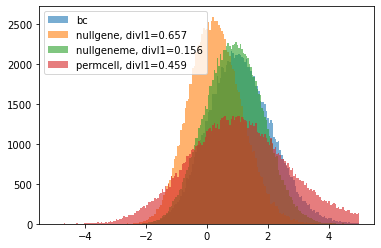

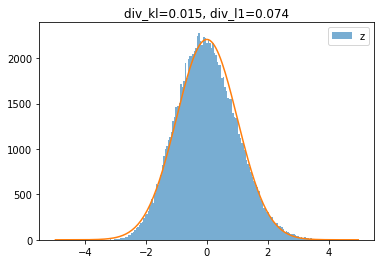

In [74]:
# Look at the score distribution
for trait in trait_list:
    print(trait)
    bins_ = np.linspace(0,1,200)
    plt.figure()
    plt.hist(data_facs_ct.obs['trs_%s'%trait], bins=bins_, alpha=0.6)
    plt.hist(data_facs_ct.obs['trs_%s_nullgene'%trait], bins=bins_, alpha=0.6, label='nullgene')
    plt.hist(data_facs_ct.obs['trs_%s_nullgeneme'%trait], bins=bins_, alpha=0.6, label='nullgeneme')
    plt.hist(data_facs_ct.obs['trs_%s_permcell'%trait], bins=bins_, alpha=0.6, label='permcell')
    plt.legend()
    plt.show()



    bins_ = np.linspace(-5,5,200)
    plt.figure()
    plt.hist(data_facs_ct.obs['trs_bc_%s'%trait], bins=bins_, alpha=0.6, label='bc')

    div_l1 = util.compute_div(data_facs_ct.obs['trs_bc_%s'%trait].values,
                              data_facs_ct.obs['trs_bc_%s_nullgene'%trait].values, opt='l1')
    plt.hist(data_facs_ct.obs['trs_bc_%s_nullgene'%trait], bins=bins_, alpha=0.6,
             label='nullgene, divl1=%0.3f'%(div_l1))

    div_l1 = util.compute_div(data_facs_ct.obs['trs_bc_%s'%trait].values,
                              data_facs_ct.obs['trs_bc_%s_nullgeneme'%trait].values, opt='l1')
    plt.hist(data_facs_ct.obs['trs_bc_%s_nullgeneme'%trait], bins=bins_, alpha=0.6,
             label='nullgeneme, divl1=%0.3f'%(div_l1))

    div_l1 = util.compute_div(data_facs_ct.obs['trs_bc_%s'%trait].values,
                              data_facs_ct.obs['trs_bc_%s_permcell'%trait].values, opt='l1')
    plt.hist(data_facs_ct.obs['trs_bc_%s_permcell'%trait], bins=bins_, alpha=0.6,
             label='permcell, divl1=%0.3f'%(div_l1))

    plt.legend()
    plt.show()



    bins_ = np.linspace(-5,5,200)
    plt.figure()
    div_kl = util.compute_div(data_facs_ct.obs['trs_bc_%s_z'%trait].values, v_norm, opt='kl')
    div_l1 = util.compute_div(data_facs_ct.obs['trs_bc_%s_z'%trait].values, v_norm, opt='l1')
    plt.hist(data_facs_ct.obs['trs_bc_%s_z'%trait], bins=bins_, alpha=0.6, label='z')

    # A normal fit
    v_loc = bins_[:-1]+(bins_[1]-bins_[0])/2
    v_norm = sp.stats.norm.pdf(v_loc) * data_facs_ct.shape[0] * (bins_[1]-bins_[0])
    plt.plot(v_loc, v_norm)

    v_norm = np.random.randn(10000)
    div_kl = util.compute_div(data_facs_ct.obs['trs_bc_%s_z'%trait].values, v_norm, opt='kl')
    div_l1 = util.compute_div(data_facs_ct.obs['trs_bc_%s_z'%trait].values, v_norm, opt='l1')
    plt.title('div_kl=%0.3f, div_l1=%0.3f'%(div_kl, div_l1))

    plt.legend()
    plt.show()

### Exploration

In [ ]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

In [ ]:
# Assign TRS
for trait in trait_list:
    
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    print('# trait=%-40s FDR<0.1 genes=%d'%(trait, len(gene_list)))
    
    # TRS score trs_
    md.score_cell(data_facs_ct, gene_list, suffix=trait, flag_correct_background=False)
    
    # background-corrected TRS score: trs_bc_ 
    md.score_cell(data_facs_ct, gene_list, suffix='bc_%s'%trait, flag_correct_background=True)

In [ ]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'raw.tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'bc.tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'raw.tc': pd.DataFrame(index=tc_list, columns=trait_list, data=0),
             'bc.tc': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    print('# %s'%trait)
    
    # 'raw.tissue' 
    temp_df = df_obs.loc[df_obs['trs_%s_bhp'%trait]<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['raw.tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # 'bc.tissue'
    temp_df = df_obs.loc[df_obs['trs_bc_%s_bhp'%trait]<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['bc.tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # 'raw.tc'
    temp_df = df_obs.loc[df_obs['trs_%s_bhp'%trait]<0.2].copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['raw.tc'].loc[temp_df.index, trait] = temp_df['cell'].values    
    
    # 'bc.tc'   
    temp_df = df_obs.loc[df_obs['trs_bc_%s_bhp'%trait]<0.2].copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['bc.tc'].loc[temp_df.index, trait] = temp_df['cell'].values

In [ ]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tc' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

In [ ]:
# Look at UMAP plot for tissue-trait pairs
plot_list = [['Brain_Non-Myeloid', 'PASS_MDD_Wray2018'],
             ['Brain_Non-Myeloid', 'PASS_ADHD_Demontis2018'],
             ['Brain_Non-Myeloid', 'PASS_SCZvsBD_Ruderfer2018'],
             ['Liver', 'PASS_LDL']]

for term in plot_list:
    tissue,trait = term
    
    sc.pl.umap(dic_data_facs[tissue], color='cell_ontology_class', save=None)
    sc.pl.umap(dic_data_facs[tissue], color='age', save=None)
    sc.pl.umap(dic_data_facs[tissue], color='sex', save=None)
    
    dic_data_facs[tissue].obs['trs_bc_%s_z'%trait] = data_facs_ct.obs.loc[dic_data_facs[tissue].obs.index,
                                                                     'trs_bc_%s_z'%trait]
    sc.pl.umap(dic_data_facs[tissue], color=['trs_bc_%s_z'%trait])

    
    

### Old code

In [ ]:
for trait in trait_list:
    
    print('# %s'%trait)
    for term in dic_assoc.keys():
        
        df_plot = dic_assoc[term].copy()
        df_plot = df_plot.loc[df_plot[trait]>1, [trait]]
        df_plot = df_plot.sort_values(by=[trait], ascending=False)
        df_plot['loc'] = np.arange(df_plot.shape[0])
        
        plt.figure(figsize=[0.3*df_plot.shape[0]+4,5])
        plt.bar(df_plot['loc'].values, df_plot[trait].values)
        plt.xticks(df_plot['loc'].values, df_plot.index, rotation=45, ha='right')
        plt.tight_layout()
        plt.title('%s    %s'%(term, trait))
        plt.show()
        
#         break
#     break    

In [ ]:
# # Visualization: 
# df_plot = df_assoc_tissue.copy()
# # df_plot = df_assoc_tc.copy()
# df_plot = df_plot.loc[df_plot.sum(axis=1)>0]
# df_plot = df_plot.sort_values(by=trait_list, ascending=False)
# print(df_plot)

In [ ]:
# # Empirical distritbution of TRS
# for trait in trait_list:
#     print('# trait=%-40s'%(trait))
#     v_trs = data_facs_ct.obs['trs_%s'%trait].values
#     v_trs = (v_trs-v_trs.mean()) / v_trs.std()
#     min_,max_ = v_trs.min(),v_trs.max()
#     plt.figure()
#     plt.hist(v_trs, bins=np.linspace(min_,max_,100))
#     plt.title('trs_%s'%trait)
#     plt.show()
    
#     v_trs = data_facs_ct.obs['trs_bc_%s'%trait]
#     v_trs = (v_trs-v_trs.mean()) / v_trs.std()
#     min_,max_ = v_trs.min(),v_trs.max()
#     plt.figure()
#     plt.hist(v_trs, bins=np.linspace(min_,max_,100))
#     plt.title('trs_bc_%s'%trait)
#     plt.show()
    

In [ ]:
df_assoc = pd.DataFrame(index=tissue_list, columns=trait_list, data=0)
for trait in trait_list:
    for tissue in tissue_list:
        print(trait, tissue)

In [ ]:
for tissue in ['Brain_Non-Myeloid', 'Marrow']:
    print(tissue)
    sc.pl.umap(dic_data_facs[tissue], color='cell_ontology_class', save=None)
for trait in trait_list:
    for tissue in ['Brain_Non-Myeloid', 'Marrow']:
        print(tissue)
        dic_data_facs[tissue].obs['trs_%s'%trait] = data_facs_ct.obs.loc[dic_data_facs[tissue].obs.index,
                                                                         'trs_%s'%trait]
        sc.pl.umap(dic_data_facs[tissue], color='trs_%s'%trait)
        dic_data_facs[tissue].obs['trs_bc_%s'%trait] = data_facs_ct.obs.loc[dic_data_facs[tissue].obs.index,
                                                                         'trs_bc_%s'%trait]
        sc.pl.umap(dic_data_facs[tissue], color='trs_bc_%s'%trait)